<a href="https://colab.research.google.com/github/WisniewskiBrian/WisniewskiBrian.github.io/blob/main/Refectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.) Import Libraries & Data

In [ ]:
import re
import nltk
import string
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keybert
from gensim import corpora
from keybert import KeyBERT
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from gensim.models import LdaModel
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Set seed for reproducibility
np.random.seed(42)

#Load dataset
data = pd.read_csv('/content/sample_data/reviews_data.csv')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  490 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB
None


In [ ]:
#Remove duplicate rows
print(data.info())
data = data.drop_duplicates()

#Display information about the data after removing duplicates
print(data.info())
#Display basic statistics of the data
print(data.describe())
#Display the count of null values in each column
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  490 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 489
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  489 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB
None
                                                   Review
count                                                 489
unique                                                489
top     You won't find better service in Columbus.  Th...
freq                                                    1
Review    0
dtype: int64


In [ ]:
#Calculate unique word lengths within Review
unique_word_lengths = data['Review'].apply(lambda x: set((word, len(word)) for word in str(x).split()))

#Find the top 5 maximum word lengths
top_5_word_lengths = sorted(
    ((word, length) for lengths in unique_word_lengths for word, length in lengths),
    key=lambda x: x[1],
    reverse=True
)[:5]

print("Top 5 word lengths:", top_5_word_lengths)

Top 5 word lengths: [('http://www.yelp.com/biz_photos/B_W4Nq3-iFWV2ato5AjXTw?select=A0GqLr7LhHMyfesbRNuogQ(WITH', 88), ('http://www.yelp.com/biz_photos/B_W4Nq3-iFWV2ato5AjXTw?select=SSHpVN0_jbmDS_zy-ztVfw(FISH', 88), ('(http://www.melonchef.com/2014/01/columbus-restaurant-week-2014-refectory.html)', 79), ('perfectly-nice-but-not-as-pricey', 32), ('venison/bison...delicious.', 26)]


In [ ]:
#Find the number of rows where word lengths exceed 45 characters
rows_exceeding_45 = (unique_word_lengths.apply(lambda lengths: any(length > 45 for _, length in lengths))).sum()

print("Number of rows with word lengths exceeding 45 characters:", rows_exceeding_45)

Number of rows with word lengths exceeding 45 characters: 2


In [ ]:
#Remove the rows exceeding 45 characters from the original dataset
filtered_data = data[~(unique_word_lengths.apply(lambda lengths: any(length > 45 for _, length in lengths)))]

#Verification showing original and filtered data
print(data.info())
print(filtered_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 489
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  489 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 489
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  487 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB
None


In [ ]:
#Locate and remove Review NaN row/values, if relevant
nan_values = data[data['Review'].isna()]
print("Rows with NaN values in 'Review':")
print(nan_values)
data = data.dropna(subset=['Review'])

Rows with NaN values in 'Review':
Empty DataFrame
Columns: [Review]
Index: []


In [ ]:
#Download NLTK stopwords
nltk.download('stopwords')

#Get the English stopwords
stop_words = set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Custom stop words for removal in next step
stop_words_custom = ['PlaceholderBrianWis']

In [ ]:
#Create a lemmatizer for both datasets
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #Convert to lowercase
    text = text.lower()

    #Tokenization
    tokens = word_tokenize(text)

    #Remove numbers
    tokens = [word for word in tokens if not re.match(r'\d', word)]

    #Remove special characters
    tokens = [word for word in tokens if word.isalnum()]

    #Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words and word.lower() not in stop_words_custom]

    #Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

print("Reviews before preprocessing")
print(data['Review'].head())

#Apply the preprocess_text function to the 'description_award' & 'solutionStatement' columns
data['Review'] = data['Review'].apply(preprocess_text)


#Print a sample of the 'description_award' & 'solutionStatement' columns after preprocessing
print("\Reviews after preprocessing:")
print(data['Review'].head())


Reviews before preprocessing
0    You won't find better service in Columbus.  Th...
1    True fine dining, The Refectory has been setti...
2    I've lost count how many times we have experie...
3    We made a reservation at Refectory for 5:15pm ...
4    This is based off a 460$ bill for 2. We both g...
Name: Review, dtype: object
\Reviews after preprocessing:
0    wo find better service columbus refectory spec...
1    true fine dining refectory setting standard co...
2    lost count many time experienced refectory one...
3    made reservation refectory saturday sent two t...
4    based bill got course chef tasting menu wine p...
Name: Review, dtype: object


In [ ]:
#Sample data
corpus = data['Review'].tolist()

#Bag of Words:
#Create a CountVectorizer instance
vectorizer = CountVectorizer(ngram_range = (1,3))

#Fit and transform the data to get the term-document matrix
X = vectorizer.fit_transform(corpus)

#Get the vocabulary and term frequencies
vocabulary = vectorizer.get_feature_names_out()
term_frequencies = X.sum(axis=0).A1

#Create a dictionary with terms and their frequencies
vocabulary_with_frequencies = dict(zip(vocabulary, term_frequencies))

#Sort the vocabulary by frequency in descending order
sorted_vocabulary_with_frequencies = dict(sorted(vocabulary_with_frequencies.items(), key=lambda item: item[1], reverse=True))

#Display the top 20 terms and their frequencies
for i, (term, frequency) in enumerate(sorted_vocabulary_with_frequencies.items()):
    print(f"{term}: {frequency}")
    if i == 19:  # Stop after displaying the top 20
        break

food: 456
restaurant: 397
service: 340
refectory: 323
experience: 296
time: 255
menu: 254
wine: 227
good: 223
great: 220
place: 220
would: 213
dish: 200
dessert: 196
one: 192
meal: 187
like: 183
dining: 175
course: 160
go: 155


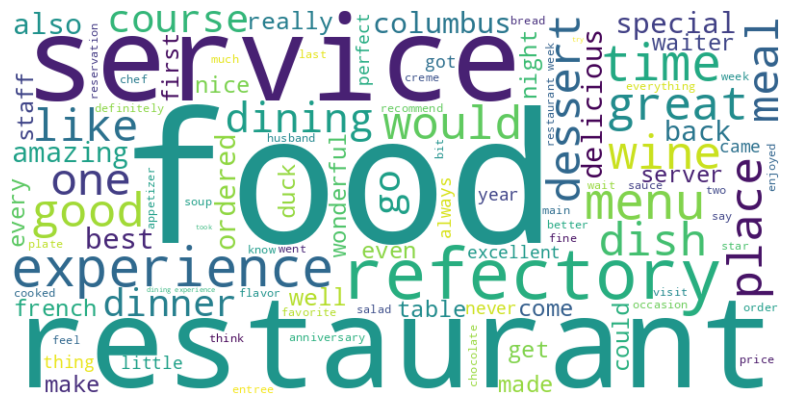

In [ ]:
#BoW word cloud
wordcloud_bow = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(vocabulary_with_frequencies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Determine optimal topic number using coherence scoring method

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, iterations=100, random_state=42)
        model_list.append(model)
        coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [ ]:
#Train LDA model with 5 topics and defined hyperparameters using BoW representation of the documents
num_topics = 5
#Defines hyperparameters
alpha_value = .0001  # Sets alpha value
beta_value = .0001  # Sets beta value

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

#Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

#Display the top words for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"\nTopic #{topic_idx + 1}")
    top_words_idx = topic.argsort()[:-21:-1]  # Get indices of top 20 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(" ".join(top_words))


Topic #1
restaurant refectory food experience service menu would time special dessert meal dinner one like place wine back dish dining columbus

Topic #2
food restaurant service refectory wine time dessert experience menu great place good like one meal dish dining best columbus night

Topic #3
food experience service restaurant good menu place refectory wine course like dining one great best would dessert time meal amazing

Topic #4
food restaurant service good great time would wine experience dish place refectory also meal menu dessert go like waiter one

Topic #5
service food experience refectory restaurant time great dish menu place columbus would one good dining well also table dessert go
